In [2]:
import os
import pandas as pd

from eval_utils import get_metrics_dict_for_path_selection_type, plot_bar_chart, get_simple_eval_metrics

ROOT = "/sailhome/esui/cs224u_final_project"

intersection max: 0.9266666666666666
union max: 0.9266666666666666
longest max: 0.9266666666666666
majority max: 0.9266666666666666
single_forward_neg max: 0.9266666666666666
baseline max: 0.9233333333333333
single_baseline max: 0.92
direction max: 0.91
single_forward max: 0.9033333333333333
forward_negation max: 0.8833333333333333
all max: 0.86
forward_randomized_order max: 0.8466666666666667
forward_all max: 0.8466666666666667
backward_negation max: 0.8133333333333334
single_backward max: 0.73
single_backward_neg max: 0.73
backward_all max: 0.72
backward_randomized_order max: 0.6766666666666666


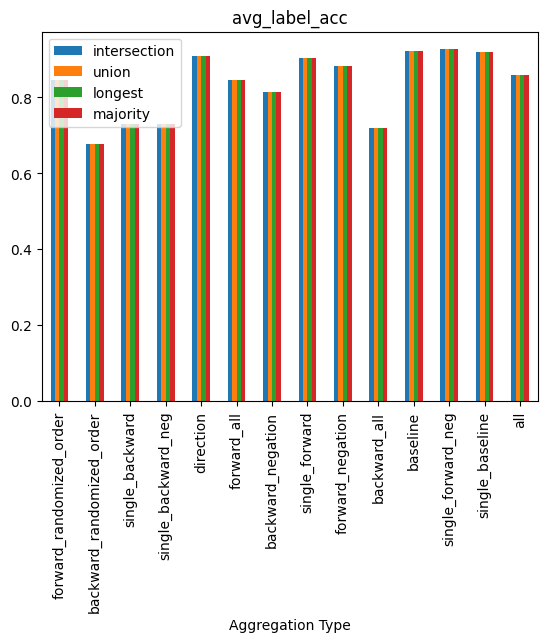

In [5]:
path_selection = "longest"
aggregate_path_glob = f'{ROOT}/prontoqa_output/fictional/aggregated/**/merge_answer_hard_*_path_select_{path_selection}.pkl'
metrics_dict, aggregation_types, merge_cot_types = get_metrics_dict_for_path_selection_type(aggregate_path_glob, path_selection)
columns = ['Aggregation Type'] + merge_cot_types

metric = "avg_label_acc"
plot_bar_chart(metric, columns, metrics_dict, aggregation_types, merge_cot_types)

majority max: 0.3933333333333333
intersection max: 0.38666666666666666
union max: 0.38666666666666666
longest max: 0.38666666666666666
single_forward_neg max: 0.3933333333333333
baseline max: 0.35333333333333333
single_baseline max: 0.35333333333333333
single_forward max: 0.35
forward_negation max: 0.3433333333333333
backward_negation max: 0.32
forward_all max: 0.31666666666666665
direction max: 0.31333333333333335
forward_randomized_order max: 0.2833333333333333
all max: 0.27666666666666667
backward_all max: 0.21666666666666667
single_backward_neg max: 0.20666666666666667
single_backward max: 0.14333333333333334
backward_randomized_order max: 0.13333333333333333


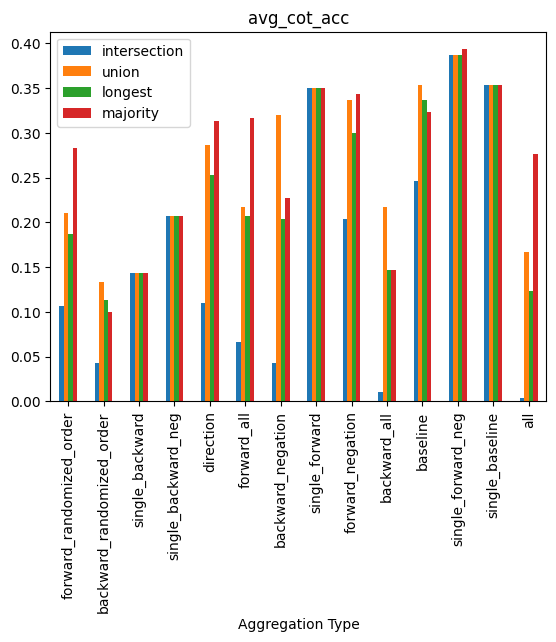

In [6]:
metric = "avg_cot_acc"
plot_bar_chart(metric, columns, metrics_dict, aggregation_types, merge_cot_types)

none max: 0.9233333333333333
baseline max: 0.9233333333333333
single_baseline max: 0.92
single_forward max: 0.8933333333333333
single_forward_neg max: 0.8866666666666667
all max: 0.85
forward_randomized_order max: 0.8466666666666667
direction max: 0.7966666666666666
forward_all max: 0.7966666666666666
single_backward max: 0.73
single_backward_neg max: 0.73
backward_randomized_order max: 0.6766666666666666
backward_all max: 0.63
forward_negation max: 0.52
backward_negation max: 0.49333333333333335


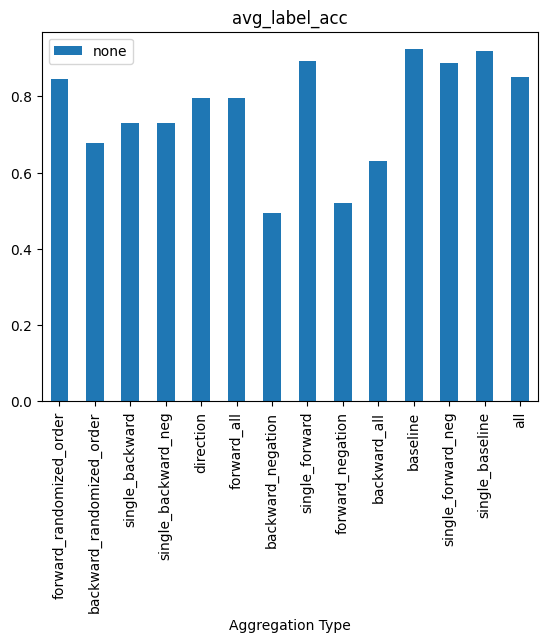

In [52]:
path_selection = "heaviest"
metrics_dict, aggregation_types, merge_cot_types = get_metrics_dict_for_path_selection_type(path_selection)

columns = ['Aggregation Type'] + merge_cot_types

metric = "avg_label_acc"
plot_bar_chart(metric, columns, metrics_dict, aggregation_types, merge_cot_types)

none max: 0.37666666666666665
forward_negation max: 0.37666666666666665
baseline max: 0.36333333333333334
direction max: 0.3
forward_all max: 0.2866666666666667
all max: 0.28
backward_negation max: 0.25
forward_randomized_order max: 0.24333333333333335
backward_all max: 0.20666666666666667
backward_randomized_order max: 0.14666666666666667


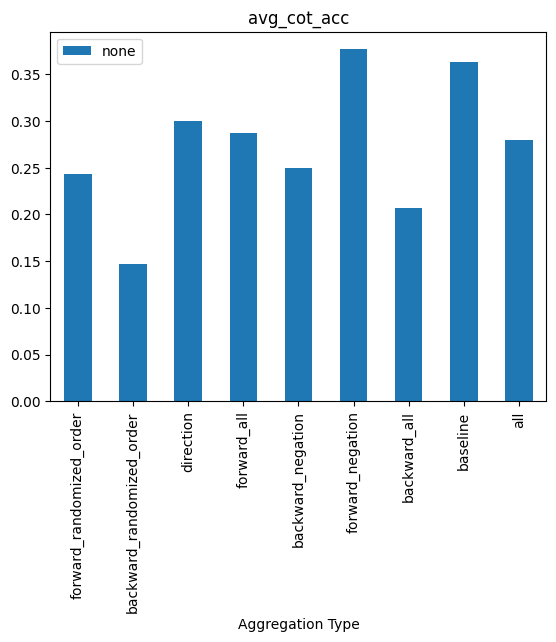

In [53]:
metric = "avg_cot_acc"
plot_bar_chart(metric, columns, metrics_dict, aggregation_types, merge_cot_types)

none max: 0.7984448391162787
baseline max: 0.7984448391162787
forward_negation max: 0.7967036220716561
backward_negation max: 0.7520378464128464
direction max: 0.7508943202623544
forward_all max: 0.6891987565238339
forward_randomized_order max: 0.6805710766987857
backward_all max: 0.6708804529234096
backward_randomized_order max: 0.6649479333732429
all max: 0.6608433568065921


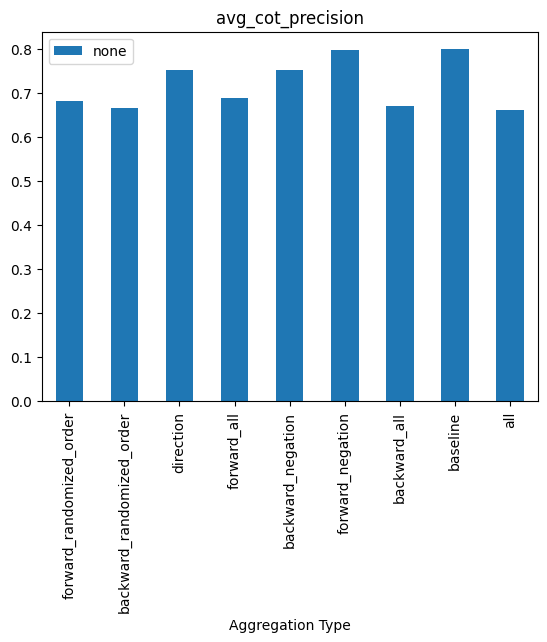

In [54]:
metric = "avg_cot_precision"
plot_bar_chart(metric, columns, metrics_dict, aggregation_types, merge_cot_types)

none max: 0.8194805194805196
forward_negation max: 0.8194805194805196
baseline max: 0.8158008658008657
forward_all max: 0.7743290043290043
forward_randomized_order max: 0.7607359307359307
direction max: 0.7583116883116884
all max: 0.7385137085137086
backward_negation max: 0.687056277056277
backward_all max: 0.6696536796536796
backward_randomized_order max: 0.6294372294372295


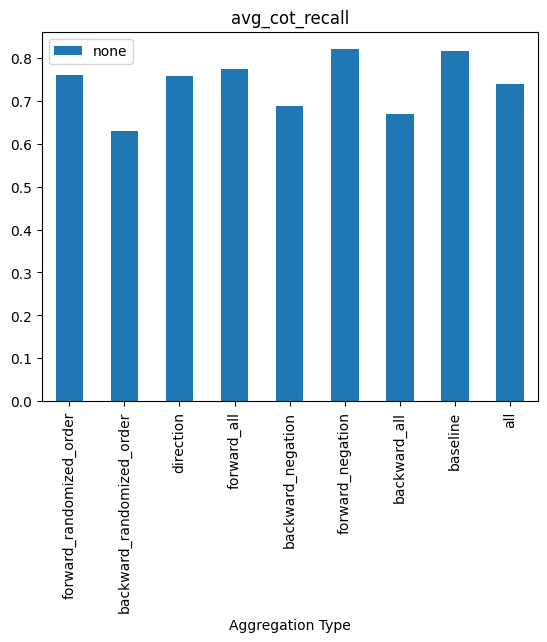

In [55]:
metric = "avg_cot_recall"
plot_bar_chart(metric, columns, metrics_dict, aggregation_types, merge_cot_types)

none max: 0.8025447367669372
forward_negation max: 0.8025447367669372
baseline max: 0.8014804450141395
direction max: 0.7466623496475193
forward_all max: 0.7186643430550058
backward_negation max: 0.7074229702597425
forward_randomized_order max: 0.7067973245857142
all max: 0.6844357283497144
backward_all max: 0.6558889995110203
backward_randomized_order max: 0.6302267067646006


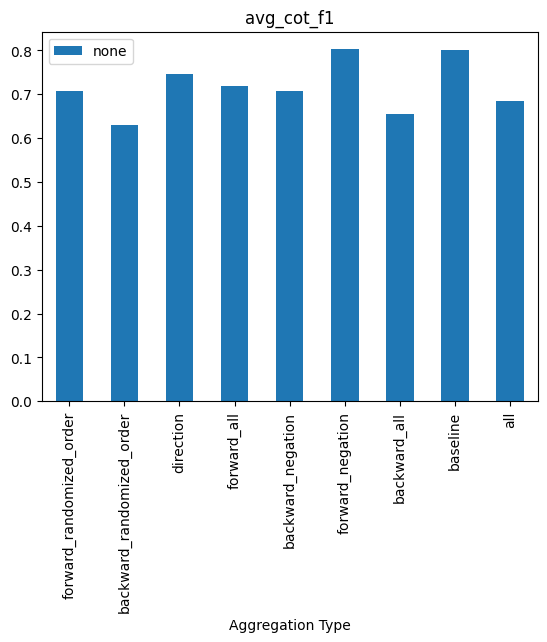

In [56]:
metric = "avg_cot_f1"
plot_bar_chart(metric, columns, metrics_dict, aggregation_types, merge_cot_types)

intersection max: 0.8651671677995206
majority max: 0.7717883055054108
longest max: 0.7269195808921041
union max: 0.7033764761153514
baseline max: 0.8651671677995206


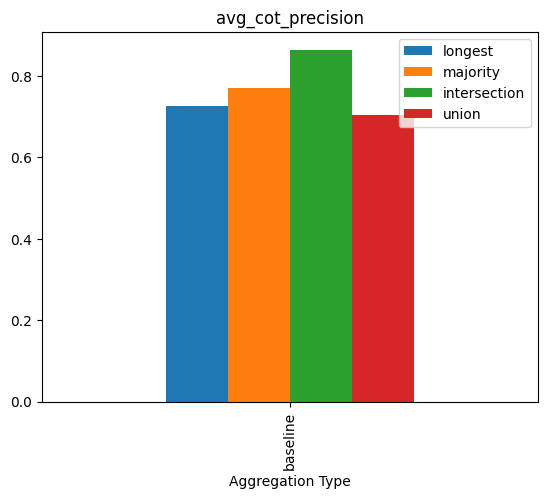

In [10]:
path_selection = "none"
metrics_dict, aggregation_types, merge_cot_types = get_metrics_dict_for_path_selection_type(path_selection)
columns = ['Aggregation Type'] + merge_cot_types

metric = "avg_cot_precision"
plot_bar_chart(metric, columns, metrics_dict, aggregation_types, merge_cot_types)

## Individual eval

In [3]:
FILES = {
        'forward_0': 'forward_1_shot_temp_0.0_seed_1234.pkl',
        'forward_1': 'forward_randomized_order_1_shot_temp_0.0_seed_1234.pkl',
        'forward_2': 'forward_randomized_order_1_shot_temp_0.0_seed_12345.pkl',
        'backward_0': 'backward_1_shot_temp_0.0_seed_1234.pkl',
        'backward_1': 'backward_randomized_order_1_shot_temp_0.0_seed_1234.pkl',
        'backward_2': 'backward_randomized_order_1_shot_temp_0.0_seed_12345.pkl',
        'forward_neg': 'forward_negated_1_shot_temp_0.0_seed_1234.pkl',
        'backward_neg': 'backward_negated_1_shot_temp_0.0_seed_1234.pkl',
        'baseline_seed1234': 'baseline_1_shot_temp_0.7_seed_1234.pkl',
        'baseline_seed5678': 'baseline_1_shot_temp_0.7_seed_5678.pkl',
        'baseline_seed910': 'baseline_1_shot_temp_0.7_seed_910.pkl',
        'forward_ltsbs': 'forward_ltsbs_1_shot_temp_0.0_seed_1234.pkl',
        'forward_ltsbs_0.7': 'forward_ltsbs_1_shot_temp_0.7_seed_1234.pkl',
        'forward_0.7': 'forward_1_shot_temp_0.7_seed_1234.pkl',
        'forward_neg_ltsbs': 'forward_negated_ltsbs_1_shot_temp_0.0_seed_1234.pkl',
        'forward_neg_ltsbs_0.7': 'forward_negated_ltsbs_1_shot_temp_0.7_seed_1234.pkl'
    }

OUTPUT_ROOT = "/sailhome/esui/cs224u_final_project/prontoqa_output/fictional"

def get_metrics_dict_for_prompt_type(prompt_type):
    if prompt_type == "forward":
        path = FILES['forward_0']
    elif prompt_type == "backward":
        path = FILES['backward_0']
    elif prompt_type == "forward_neg":
        path = FILES['forward_neg']
    elif prompt_type == "backward_neg":
        path = FILES['backward_neg']
    elif prompt_type == "baseline":
        path = FILES['baseline_seed1234']
    elif prompt_type in ["forward_0.7", "forward_ltsbs", "forward_ltsbs_0.7", "forward_neg_ltsbs", "forward_neg_ltsbs_0.7"]:
        path = FILES[prompt_type]
    else:
        raise NotImplementedError(f'prompt_type {prompt_type} not queried')

    path = os.path.join(OUTPUT_ROOT, 'converted', path)

    metrics_dict = get_simple_eval_metrics(path)
    return metrics_dict

def get_data_for_all_metrics(metric, metrics_dict, prompt_types):
    data = []
    for metric in metrics_dict[prompt_types[0]].keys():
        data_metric = [metric]
        for prompt_type in prompt_types:
            data_metric.append(metrics_dict[prompt_type][metric])
        data.append(data_metric)
    return data

              metric   forward  forward_0.7  forward_ltsbs  forward_ltsbs_0.7   
0      avg_label_acc  0.893333     0.890000       0.903333           0.906667  \
1        avg_cot_acc  0.270000     0.240000       0.300000           0.266667   
2  avg_cot_precision  0.736858     0.715390       0.753849           0.736826   
3     avg_cot_recall  0.802597     0.779192       0.810722           0.797734   
4         avg_cot_f1  0.759750     0.737156       0.773616           0.757341   

   backward  forward_neg  backward_neg  baseline  forward_neg_ltsbs   
0  0.730000     0.886667      0.730000  0.920000           0.926667  \
1  0.066667     0.300000      0.116667  0.263333           0.320000   
2  0.604671     0.759936      0.653389  0.751638           0.781349   
3  0.635830     0.822323      0.679076  0.790188           0.838543   
4  0.604233     0.781737      0.652136  0.763150           0.800951   

   forward_neg_ltsbs_0.7  
0               0.900000  
1               0.280000  
2    

<Axes: title={'center': 'individual eval'}, xlabel='metric'>

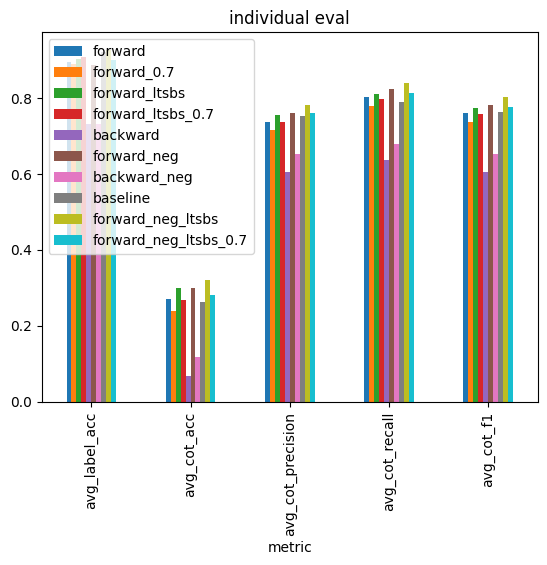

In [4]:
PROMPT_TYPES = ["forward", "forward_0.7", "forward_ltsbs", "forward_ltsbs_0.7", "backward", "forward_neg", "backward_neg", "baseline", "forward_neg_ltsbs", "forward_neg_ltsbs_0.7"]
columns = ["metric"] + PROMPT_TYPES
metric = "avg_label_acc"
metrics_dict = {}
for prompt_type in PROMPT_TYPES:
    metrics_dict[prompt_type] = get_metrics_dict_for_prompt_type(prompt_type)

data = get_data_for_all_metrics(metric, metrics_dict, PROMPT_TYPES)

metrics_df = pd.DataFrame(
            columns=columns,
            data=data
)

print(metrics_df)

metrics_df.plot(x='metric',
    kind='bar',
    stacked=False,
    title="individual eval"
)